In [2]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import seaborn as sns
from nltk.sem.chat80 import country
from statsmodels.genmod.families.links import loglog

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import create_tmdb_dataset
from src.utils.load_data import load_raw_data
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.models.lda_model import *

[nltk_data] Downloading package stopwords to /Users/chsce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = create_tmdb_dataset('data/processed/TMDB_clean.csv')
df.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate es...","[action, science fiction, adventure]","[legendary pictures, syncopy, warner bros. pic...","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, fran...",2010,during
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who mak...,"[adventure, drama, science fiction]","[legendary pictures, syncopy, lynda obst produ...","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time...",2014,post
2,the dark knight,2008-07-16,1004558444,152,185000000,en,batman raises the stakes in his war on crime. ...,"[drama, action, crime, thriller]","[dc comics, legendary pictures, syncopy, isobe...","[united kingdom, united states of america]","[english, mandarin]","[joker, sadism, chaos, secret identity, crime ...",2008,during
3,avatar,2009-12-15,2923706026,162,237000000,en,"in the 22nd century, a paraplegic marine is di...","[action, adventure, fantasy, science fiction]","[dune entertainment, lightstorm entertainment,...","[united states of america, united kingdom]","[english, spanish]","[future, society, culture clash, space travel,...",2009,during
4,the avengers,2012-04-25,1518815515,143,220000000,en,when an unexpected enemy emerges and threatens...,"[science fiction, action, adventure]",[marvel studios],[united states of america],"[english, hindi, russian]","[new york city, superhero, shield, based on co...",2012,during


In [4]:
df[(df.budget > 0) & (df.budget < 1e2)].budget.describe()

count    1428.000000
mean       25.213585
std        26.076351
min         1.000000
25%         5.000000
50%        15.000000
75%        45.000000
max        99.000000
Name: budget, dtype: float64

In [78]:
df = df[(df.budget ==0) | (df.budget > 1e2)]

In [79]:
def calculate_roi(df):
    if df.revenue > 0 and df.budget > 0:
        return (df.revenue - df.budget) / df.budget * 100
    else: 
        return 0
    
df['roi'] = df.apply(calculate_roi, axis=1)

In [80]:
df[df.roi >0]['roi'].describe()

count    5.790000e+03
mean     2.681698e+04
std      1.784724e+06
min      2.000000e-04
25%      8.129991e+01
50%      1.935793e+02
75%      4.329522e+02
max      1.351350e+08
Name: roi, dtype: float64

In [81]:
mean_budgets = df[df.budget > 0].groupby('release_year').agg(mean_budget = ('budget', 'mean'))

def categorize_production(row, means):
    mean_budget = means.loc[row.release_year, 'mean_budget']
    if row['budget'] < 0.1 * mean_budget:
        return 'Independent'
    elif row['budget'] < mean_budget:
        return 'Small'
    elif row['budget'] < 5 * mean_budget:
        return 'Big'
    else:
        return 'Super'
    
df['prod_type'] = df.apply(categorize_production, axis=1, args=(mean_budgets,))

In [82]:
df[df.roi > 0].roi.describe()

count    5.790000e+03
mean     2.681698e+04
std      1.784724e+06
min      2.000000e-04
25%      8.129991e+01
50%      1.935793e+02
75%      4.329522e+02
max      1.351350e+08
Name: roi, dtype: float64

<Axes: xlabel='release_year', ylabel='mean_roi'>

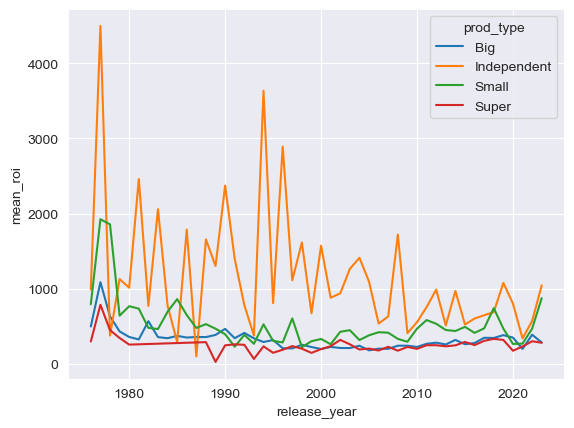

In [335]:
sns.lineplot(
    df[(df.roi > 0) & (df.roi <1e4)].groupby(['release_year', 'prod_type']).agg(mean_roi=('roi', 'mean')).reset_index(),
    x='release_year', y='mean_roi', hue='prod_type')

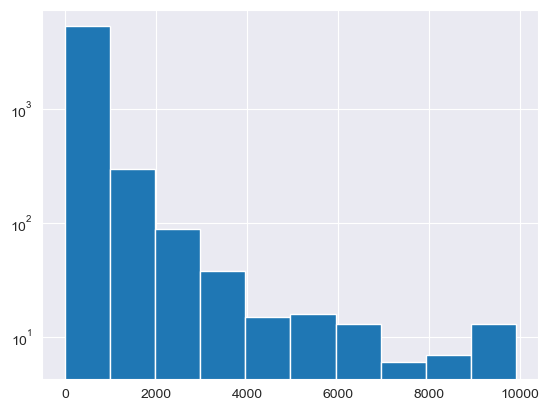

In [334]:
plt.hist(df[(df.roi > 0) & (df.roi < 1e4)].roi)
plt.yscale('log')

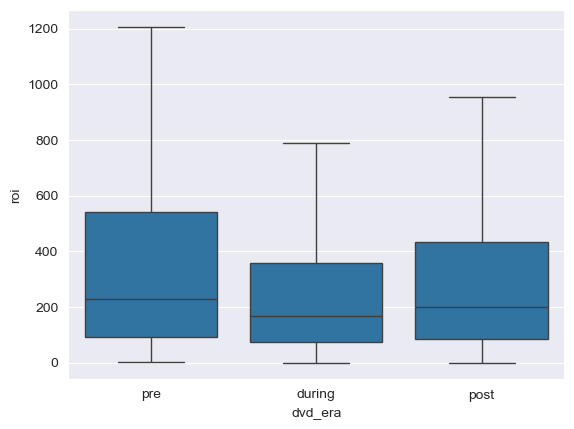

In [333]:
sns.boxplot(data=df[(df.roi > 0) & (df.roi < 6e3)], x='dvd_era', y='roi', showfliers=False, order=['pre', 'during', 'post'])
plt.show()

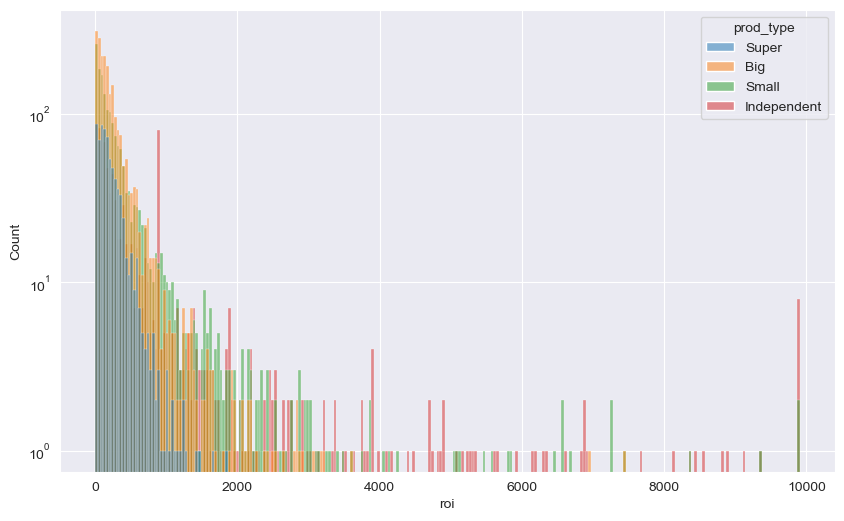

In [332]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[(df.roi > 0) & (df.roi < 1e4)], x='roi', hue='prod_type')
plt.yscale('log')
plt.show()

In [337]:
contingency_table = pd.crosstab(df[df.budget >0]['dvd_era'], df[df.budget >0]['prod_type']).reindex(['pre', 'during', 'post'])[['Independent', 'Small', 'Big', 'Super']]
print(contingency_table)


prod_type  Independent  Small   Big  Super
dvd_era                                   
pre                703   1085  1051     31
during            3708   3081  1841    400
post              6129   2494  1231    532


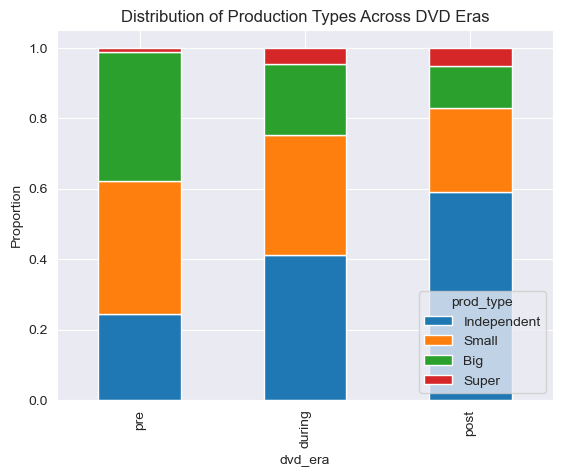

In [338]:
era_proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
era_proportions.plot(kind='bar', stacked=True)
plt.ylabel('Proportion')
plt.title('Distribution of Production Types Across DVD Eras')
plt.show()

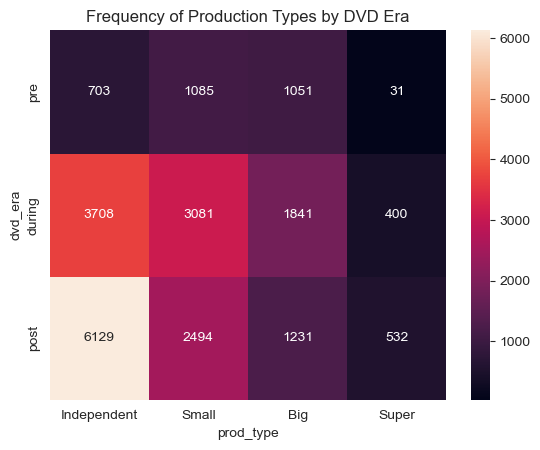

In [339]:
sns.heatmap(contingency_table, annot=True, fmt="d")
plt.title("Frequency of Production Types by DVD Era")
plt.show()

In [340]:
from statsmodels.stats.proportion import proportions_ztest

count = contingency_table['Super']
total = contingency_table.sum(axis=1)
z_stat, p_value = proportions_ztest([count['pre'], count['during']], [total['pre'], total['during']])
print(f"Z-Statistic: {z_stat}, P-Value: {p_value}")


Z-Statistic: -8.366464897025406, P-Value: 5.937259756677127e-17


In [341]:
movies = df.copy()
movies = movies[movies.genres.apply(lambda x: len(x) > 0)]

# Explode the genres column
movies_exploded = movies.explode('genres')
movies['dvd_era'] = pd.Categorical(movies['dvd_era'], categories=['pre', 'during', 'post'], ordered=True)
movies['prod_type'] = pd.Categorical(movies['prod_type'], categories=['Independent', 'Small', 'Big', 'Super'], ordered=True)
# Verify the expanded data
movies_exploded.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era,roi,prod_type,success_type
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: ""inception"", the implantation of another person's idea into a target's subconscious.",action,"[legendary pictures, syncopy, warner bros. pictures]","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, france, virtual reality, kidnapping, philosophy, spy, allegory, manipulation, car crash, heist, memory, architecture, los angeles, california, dream world, subconscious]",2010,during,415.957978,Super,Super
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: ""inception"", the implantation of another person's idea into a target's subconscious.",science fiction,"[legendary pictures, syncopy, warner bros. pictures]","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, france, virtual reality, kidnapping, philosophy, spy, allegory, manipulation, car crash, heist, memory, architecture, los angeles, california, dream world, subconscious]",2010,during,415.957978,Super,Super
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: ""inception"", the implantation of another person's idea into a target's subconscious.",adventure,"[legendary pictures, syncopy, warner bros. pictures]","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, france, virtual reality, kidnapping, philosophy, spy, allegory, manipulation, car crash, heist, memory, architecture, los angeles, california, dream world, subconscious]",2010,during,415.957978,Super,Super
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.,adventure,"[legendary pictures, syncopy, lynda obst productions]","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time, artificial intelligence (a.i.), nasa, time warp, dystopia, expedition, space travel, wormhole, famine, black hole, quantum mechanics, family relationships, space, robot, astronaut, scientist, single father, farmer, space station, curious, space adventure, time paradox, thoughtful, time-manipulation, father daughter relationship, 2060s, cornfield, time manipulation, complicated]",2014,post,325.290428,Super,Super
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.,drama,"[legendary pictures, syncopy, lynda obst productions]","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time, artificial intelligence (a.i.), nasa, time warp, dystopia, expedition, space travel, wormhole, famine, black hole, quantum mechanics, family relationships, space, robot, astronaut, scientist, single father, farmer, space station, curious, space adventure, time paradox, thoughtful, time-manipulation, father daughter relationship, 2060s, cornfield, t

In [342]:
# Count occurrences of each genre within production types and DVD eras
genre_counts = (
    movies_exploded.groupby(['prod_type', 'dvd_era', 'genres'])
    .size()
    .reset_index(name='count')
)

# Total count of genres per production type and DVD era
total_counts = (
    movies_exploded.groupby(['prod_type', 'dvd_era'])
    .size()
    .reset_index(name='total')
)

# Merge to compute proportions
genre_proportions = genre_counts.merge(
    total_counts,
    on=['prod_type', 'dvd_era']
)
genre_proportions['proportion'] = (
    genre_proportions['count'] / genre_proportions['total']
)


In [343]:
mindex = pd.MultiIndex.from_arrays([['Independent','Independent', 'Independent', 'Small','Small','Small', 'Big','Big','Big', 'Super', 'Super', 'Super'], ['pre', 'during', 'post']*4], names=('prod_type', 'dvd_era'))

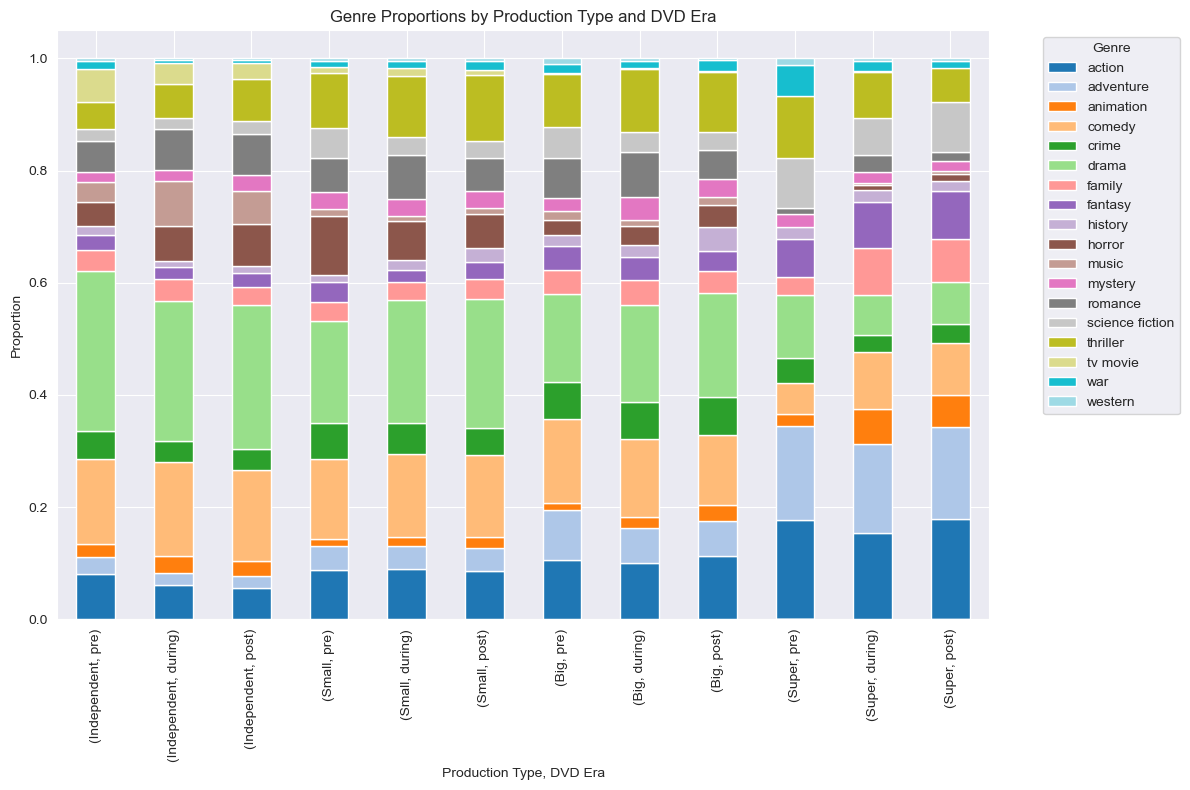

In [344]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot data for easier plotting
pivot_data = genre_proportions.pivot_table(
    index=['prod_type', 'dvd_era'],
    columns='genres',
    values='proportion',
    fill_value=0
).reindex(mindex)

# Plot
pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    colormap='tab20'
)
plt.title('Genre Proportions by Production Type and DVD Era')
plt.xlabel('Production Type, DVD Era')
plt.ylabel('Proportion')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/d3/9chl4s4x2w1dxn5y2k9m88fc0000gn/T/ipykernel_11511/2374235087.py:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



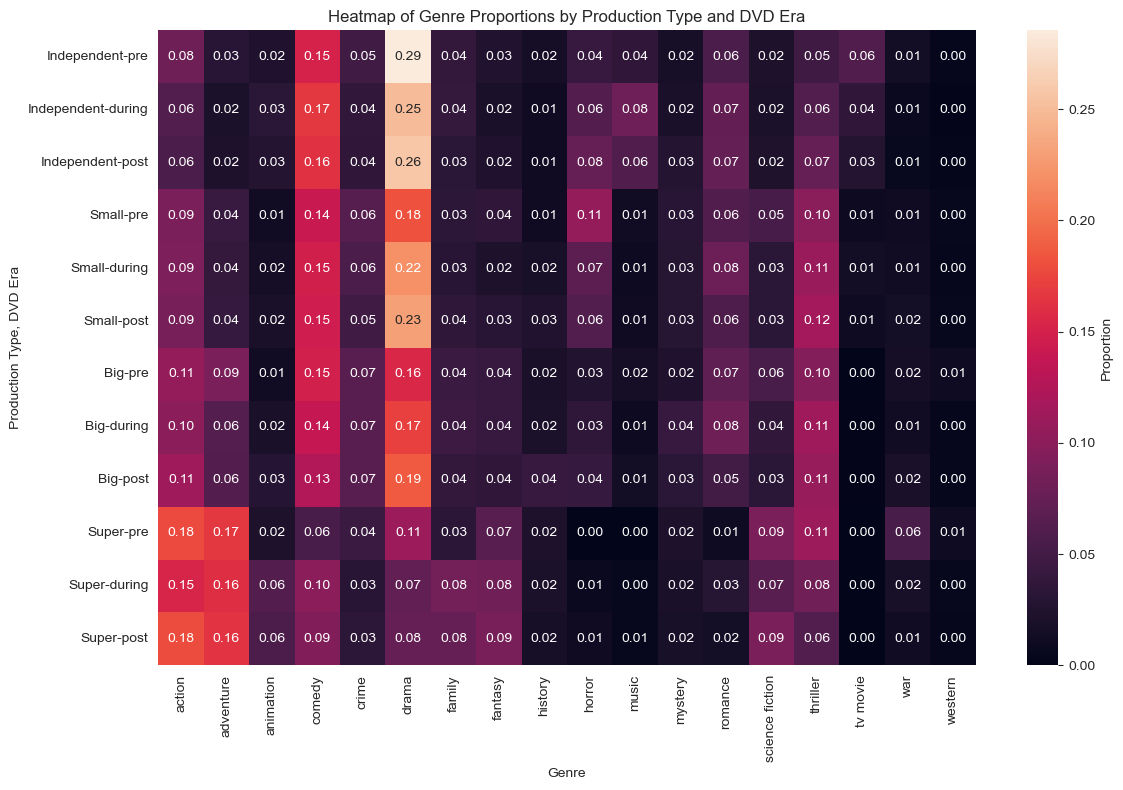

In [350]:
# Create a pivot table
heatmap_data = genre_proportions.pivot_table(
    index=['prod_type', 'dvd_era'],
    columns='genres',
    values='proportion',
    fill_value=0
).reindex(mindex)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Proportion'}
)
plt.title('Heatmap of Genre Proportions by Production Type and DVD Era')
plt.xlabel('Genre')
plt.ylabel('Production Type, DVD Era')
plt.tight_layout()
plt.show()



In [355]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact

movies_exploded = movies.explode('genres')

# Count the occurrences of genres by prod_type and dvd_era
genre_counts = (
    movies_exploded.groupby(['prod_type', 'dvd_era', 'genres'])
    .size()
    .reset_index(name='count')
)

# Get total counts per prod_type and dvd_era combination
total_counts = (
    movies_exploded.groupby(['prod_type', 'dvd_era'])
    .size()
    .reset_index(name='total')
)

# Merge counts with totals to calculate proportions
genre_proportions = genre_counts.merge(total_counts, on=['prod_type', 'dvd_era'])
genre_proportions['proportion'] = genre_proportions['count'] / genre_proportions['total']

# Create a pivot table for the heatmap
pivot_data = genre_proportions.pivot_table(
    index='prod_type',  
    columns='dvd_era',  
    values='proportion',
    fill_value=0
)

def plot_heatmap(fixed_value, fixed_type='prod_type'):
    if fixed_type == 'prod_type':
        filtered_data = genre_proportions[genre_proportions['prod_type'] == fixed_value]
    else:
        filtered_data = genre_proportions[genre_proportions['dvd_era'] == fixed_value]

    pivot_filtered = filtered_data.pivot_table(
        index='prod_type' if fixed_type == 'dvd_era' else 'dvd_era', 
        columns='genres', 
        values='proportion', 
        fill_value=0, 
        observed=False
    )

    # Create a heatmap
    fig = px.imshow(
        pivot_filtered,
        color_continuous_scale='Blues',
        labels={'x': 'Genre', 'y': 'Production Type' if fixed_type == 'dvd_era' else 'DVD Era'},
        title=f'Heatmap for {fixed_value} ({fixed_type})',
        text_auto=True,
    )

    fig.show()
    plt.show()

# Create widgets for selection
prod_type_selector = widgets.Dropdown(
    options=movies['prod_type'].unique(),
    description='Production Type:'
)

dvd_era_selector = widgets.Dropdown(
    options=movies['dvd_era'].unique(),
    description='DVD Era:'
)

interact(plot_heatmap, fixed_value=prod_type_selector, fixed_type=widgets.fixed('prod_type'))



/var/folders/d3/9chl4s4x2w1dxn5y2k9m88fc0000gn/T/ipykernel_11511/4072053651.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/d3/9chl4s4x2w1dxn5y2k9m88fc0000gn/T/ipykernel_11511/4072053651.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/d3/9chl4s4x2w1dxn5y2k9m88fc0000gn/T/ipykernel_11511/4072053651.py:27: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



interactive(children=(Dropdown(description='Production Type:', options=('Super', 'Big', 'Small', 'Independent'…

<function __main__.plot_heatmap(fixed_value, fixed_type='prod_type')>

In [166]:
interact(plot_heatmap, fixed_value=dvd_era_selector, fixed_type=widgets.fixed('dvd_era'))

interactive(children=(Dropdown(description='DVD Era:', options=('during', 'post', 'pre'), value='during'), Out…

<function __main__.plot_heatmap(fixed_value, fixed_type='prod_type')>

In [353]:
pivot_data.loc['Small']

dvd_era
pre       0.055556
during    0.055556
post      0.055556
Name: Small, dtype: float64

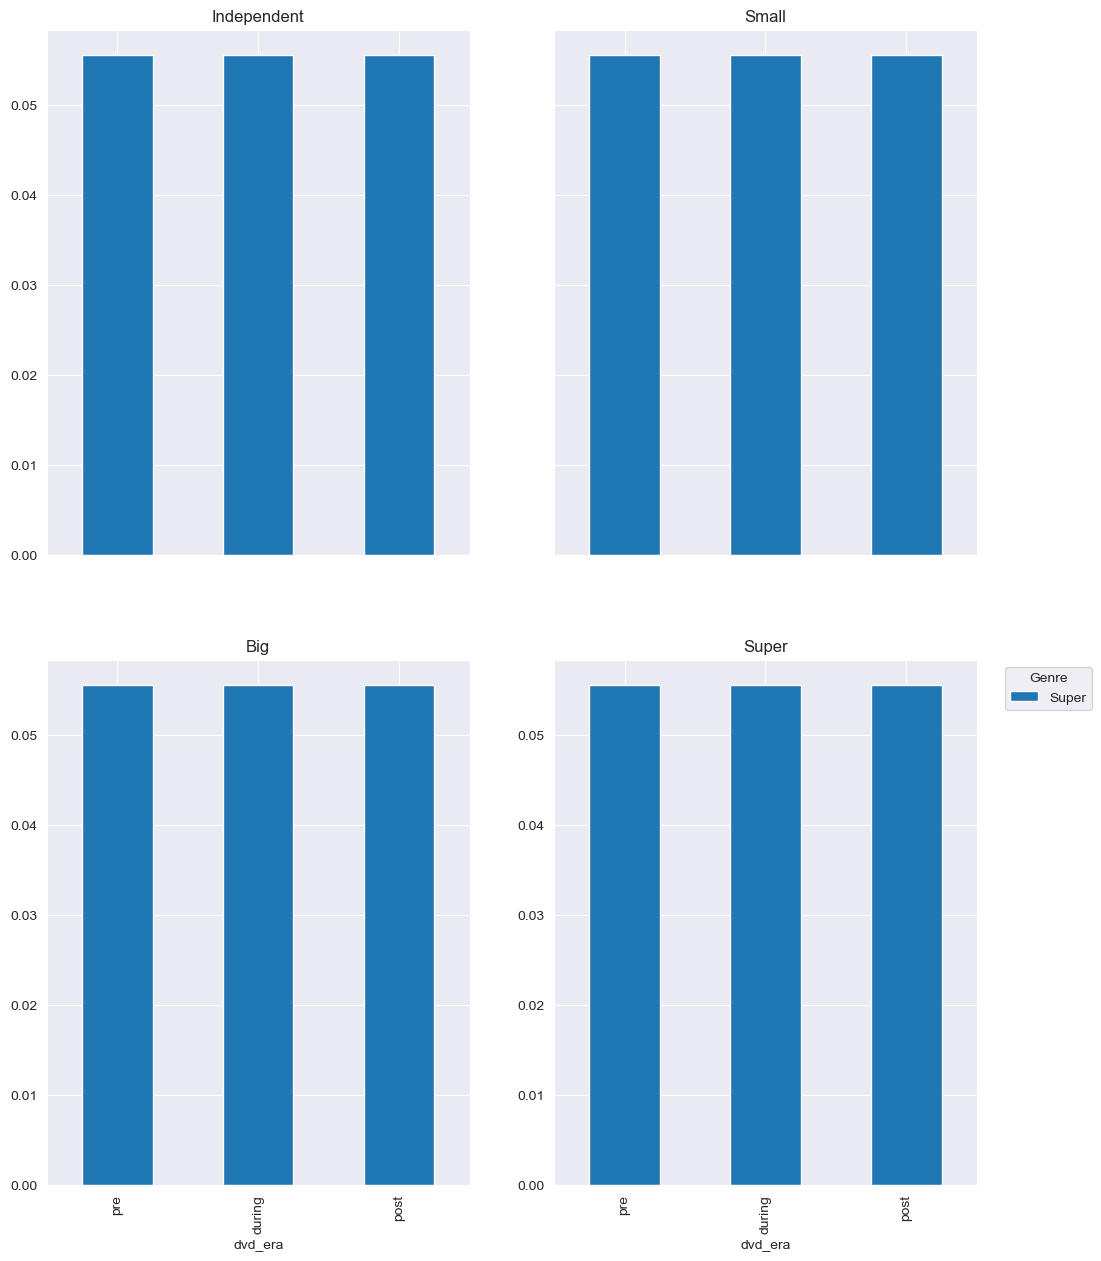

In [356]:
f, axs = plt.subplots(2, 2, figsize=(12, 15), sharex=True, sharey=True)

for ax, prod in zip(axs.flatten(), genre_proportions.prod_type.unique()):
    data_prod = pivot_data.loc[prod]
    data_prod.plot(kind='bar', stacked=True, ax=ax, legend=False)
    ax.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)
    ax.set_title(prod)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# revenue 

In [357]:
mean_revenue= df[df.revenue > 0].groupby('release_year').agg(mean_revenue = ('revenue', 'mean'))

def categorize_revenue(row, means):
    mean_revenue = means.loc[row.release_year, 'mean_revenue']
    if row['revenue'] < 0.1 * mean_revenue:
        return 'Low'
    elif row['revenue'] < mean_revenue:
        return 'Mid'
    elif row['revenue'] < 5 * mean_revenue:
        return 'Big'
    else:
        return 'Super'
    
df['success_type'] = df.apply(categorize_revenue, axis=1, args=(mean_revenue,))

In [358]:
df.groupby('success_type').size()

success_type
Big        2349
Low      352595
Mid        4529
Super       714
dtype: int64

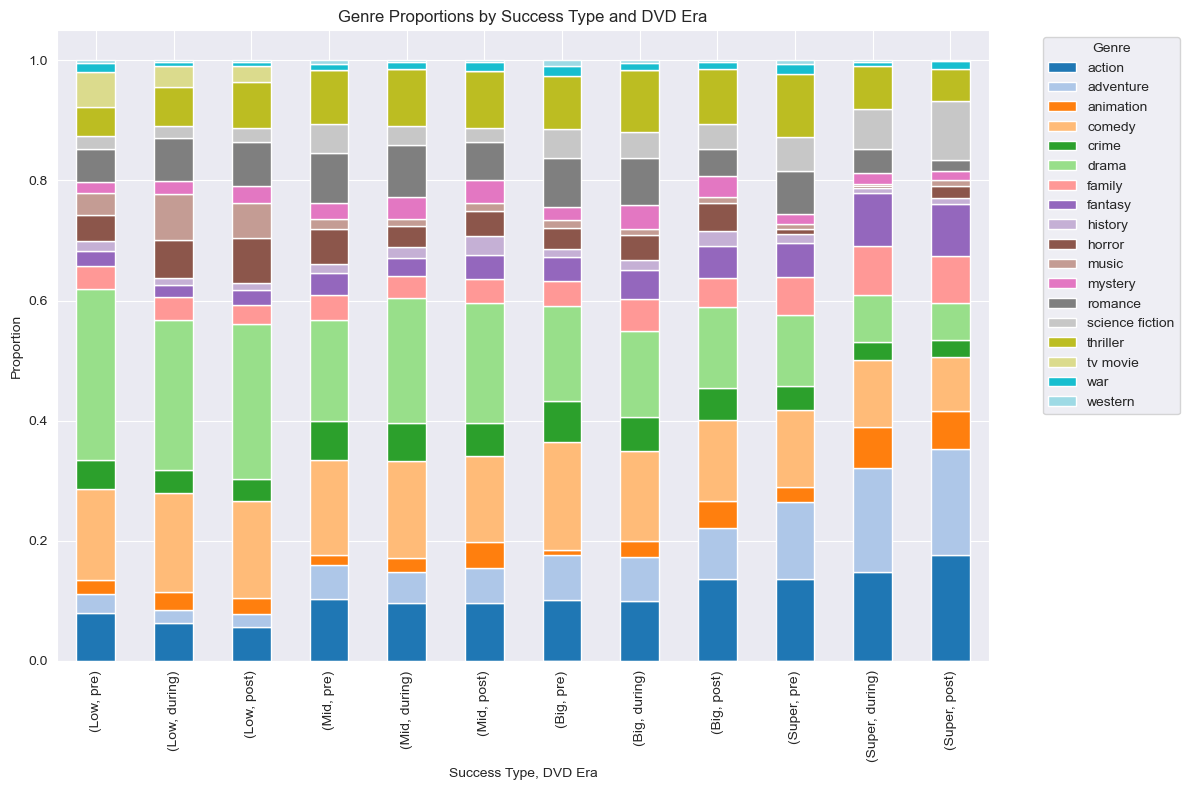

In [359]:
movies = df.copy()
# Explode the genres column
movies = movies[movies.genres.apply(lambda x: len(x) > 0)]
movies_exploded = movies.explode('genres')
movies['dvd_era'] = pd.Categorical(movies['dvd_era'], categories=['pre', 'during', 'post'], ordered=True)
movies['success_type'] = pd.Categorical(movies['success_type'], categories=['Low', 'Mid', 'Big', 'Super'], ordered=True)
# Verify the expanded data
movies_exploded.head()

# Count occurrences of each genre within production types and DVD eras
genre_counts = (
    movies_exploded.groupby(['success_type', 'dvd_era', 'genres'])
    .size()
    .reset_index(name='count')
)

# Total count of genres per production type and DVD era
total_counts = (
    movies_exploded.groupby(['success_type', 'dvd_era'])
    .size()
    .reset_index(name='total')
)

# Merge to compute proportions
genre_proportions = genre_counts.merge(
    total_counts,
    on=['success_type', 'dvd_era']
)
genre_proportions['proportion'] = (
    genre_proportions['count'] / genre_proportions['total']
)

mindex = pd.MultiIndex.from_arrays([['Low','Low', 'Low', 'Mid','Mid','Mid', 'Big','Big','Big', 'Super', 'Super', 'Super'], ['pre', 'during', 'post']*4], names=('success_type', 'dvd_era'))

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot data for easier plotting
pivot_data = genre_proportions.pivot_table(
    index=['success_type', 'dvd_era'],
    columns='genres',
    values='proportion',
    fill_value=0
).reindex(mindex)

# Plot
pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    colormap='tab20'
)
plt.title('Genre Proportions by Success Type and DVD Era')
plt.xlabel('Success Type, DVD Era')
plt.ylabel('Proportion')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [29]:
import pandas as pd
from scipy.stats import chi2_contingency

success_types = genre_proportions['success_type'].unique()
genres = genre_proportions['genres'].unique()
results = []
for success_type in success_types:
    contingency_table = genre_proportions[(genre_proportions.success_type == success_type)].pivot_table(index='genres', columns='dvd_era', values='proportion').fillna(0) * 100

    chi2, p, _, _ = chi2_contingency([contingency_table])
    results.append({'success_type': success_type,'chi2': chi2, 'p_value': p})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

,success_type,chi2,p_value
0,Big,8.592359,0.999997
1,Low,7.047174,1.000000
2,Mid,5.295682,1.000000
3,Super,17.363079,0.983523


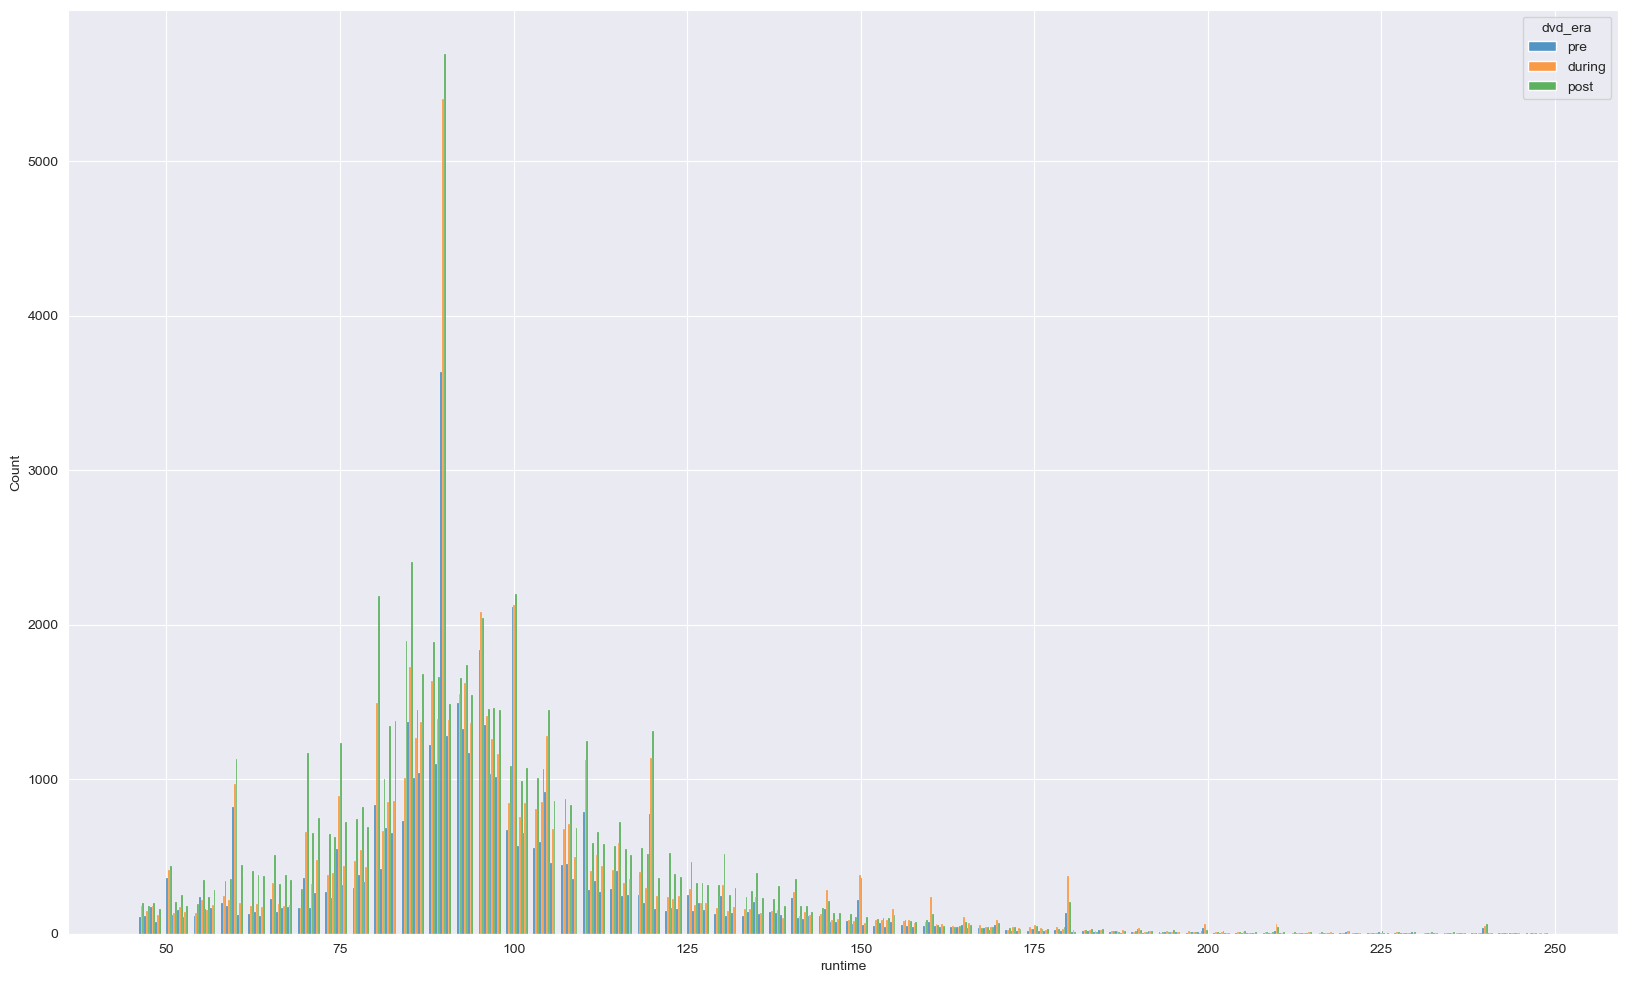

In [57]:
plt.figure(figsize=(20,12))
sns.histplot(data=movies[(movies.runtime > 0) & (movies.runtime < 250)], x='runtime', hue='dvd_era', multiple='dodge')
plt.show()

In [51]:
language_counts = movies.groupby('original_language').size().sort_values(ascending=False).reset_index(name='count')
languages = language_counts[language_counts['count'] > 200].original_language
languages

0     en
1     ja
2     fr
3     de
4     es
5     zh
6     ru
7     it
8     pt
9     ko
10    hi
11    cn
12    ta
13    tl
14    tr
15    cs
16    ml
17    nl
18    id
19    ar
20    pl
21    te
22    sv
23    th
24    bn
25    el
26    da
27    fa
28    hu
29    sk
30    ms
31    fi
32    no
33    kn
34    ro
35    he
36    sr
37    mr
38    sh
39    pa
40    vi
41    bg
42    kk
43    uk
44    hr
45    sl
46    lv
47    ca
48    et
49    ur
50    sq
51    az
52    mn
53    lt
54    is
55    ka
Name: original_language, dtype: object

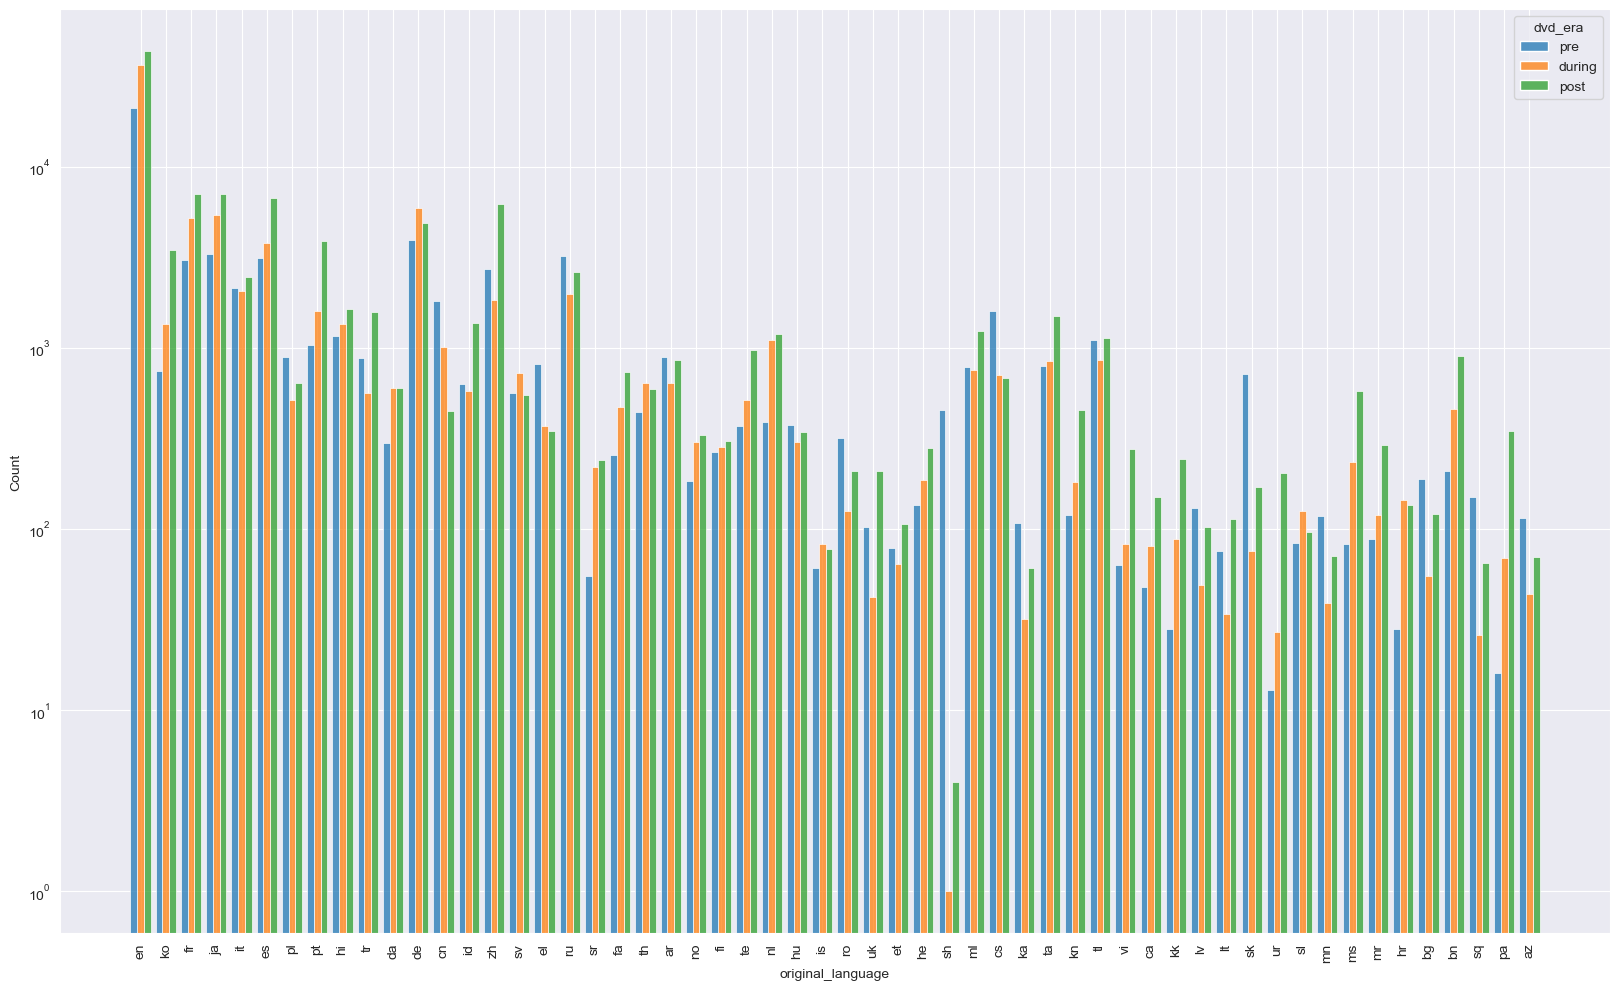

In [54]:
plt.figure(figsize=(20,12))
sns.histplot(data=movies[movies.original_language.isin(languages.tolist())], x='original_language', hue='dvd_era', multiple='dodge', shrink=0.8)
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

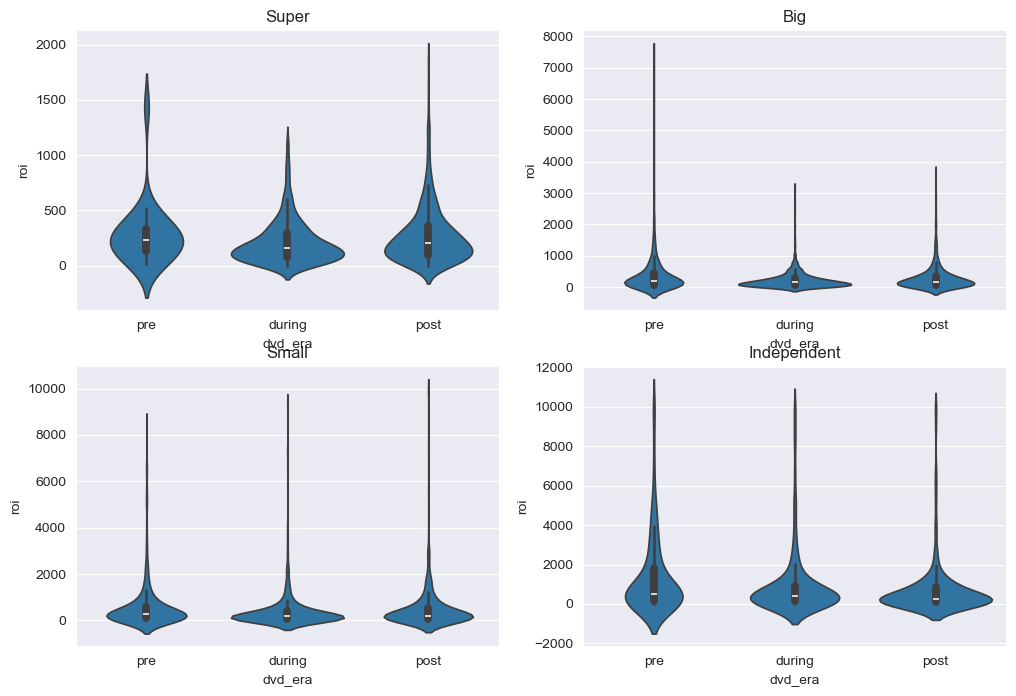

In [97]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
for i, prod in enumerate(df.prod_type.unique()):
    sns.violinplot(data=df[(df.roi > 0) & (df.roi < 1e4) & (df.prod_type == prod)], x='dvd_era', y='roi', order=['pre', 'during', 'post'], ax=axs.flatten()[i])
    axs.flatten()[i].set_title(prod)
plt.show()

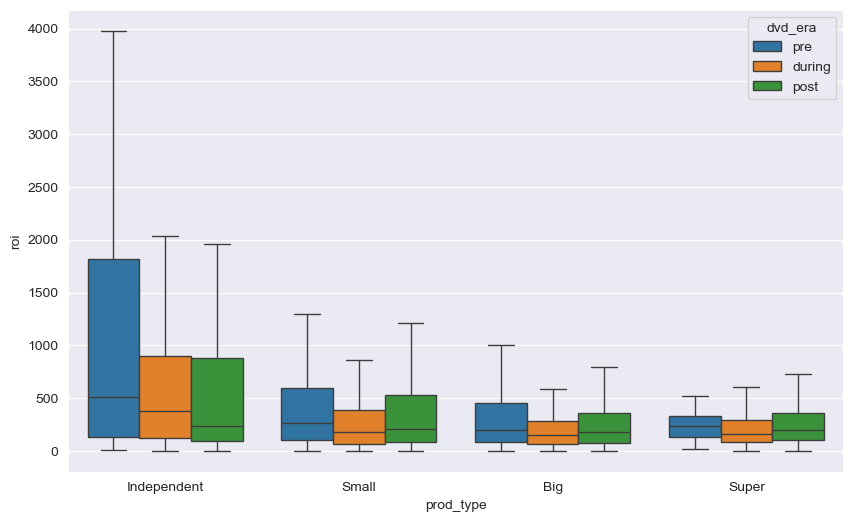

In [113]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[(df.roi > 0) & (df.roi < 1e4)], x='prod_type', y='roi', hue='dvd_era',
               order=['Independent', 'Small', 'Big', 'Super'], hue_order=['pre', 'during', 'post'], showfliers=False)
plt.show()

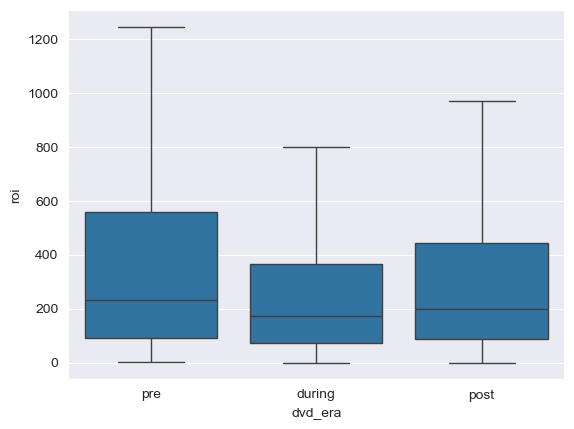

In [114]:
sns.boxplot(data=df[(df.roi > 0) & (df.roi < 1e4)], x='dvd_era', y='roi', order=['pre', 'during', 'post'], showfliers=False)
plt.show()

In [117]:
movies_filtered = movies_exploded[movies_exploded['roi'] > 0]

In [119]:
movies_filtered.columns

Index(['title', 'release_date', 'revenue', 'runtime', 'budget',
       'original_language', 'overview', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'keywords', 'release_year',
       'dvd_era', 'roi', 'prod_type', 'success_type'],
      dtype='object')

In [212]:
features = ['runtime', 'release_year', 'genres', 'budget']
target = ['revenue']

X = movies_filtered[features]
y = movies_filtered[target]

In [213]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
scaler = StandardScaler()
X = pd.get_dummies(X)
print(X.columns)
new_features = X.columns
print(X.shape)
print(new_features.shape)
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)
X_scaled = sm.add_constant(X_scaled)

Index(['runtime', 'release_year', 'budget', 'genres_action',
       'genres_adventure', 'genres_animation', 'genres_comedy', 'genres_crime',
       'genres_drama', 'genres_family', 'genres_fantasy', 'genres_history',
       'genres_horror', 'genres_music', 'genres_mystery', 'genres_romance',
       'genres_science fiction', 'genres_thriller', 'genres_tv movie',
       'genres_war', 'genres_western'],
      dtype='object')
(14982, 21)
(21,)
(14982, 21)


In [197]:
new_features = new_features.insert(0, 'const')

In [198]:
# import linear regression
from statsmodels.regression.linear_model import OLS

model = sm.OLS(np.asarray(y), pd.DataFrame(X_scaled, columns=new_features))
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1291.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:31:57   Log-Likelihood:            -2.7882e+05
No. Observations:               14982   AIC:                         5.577e+05
Df Residuals:                   14961   BIC:                         5.578e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3.48

/opt/homebrew/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



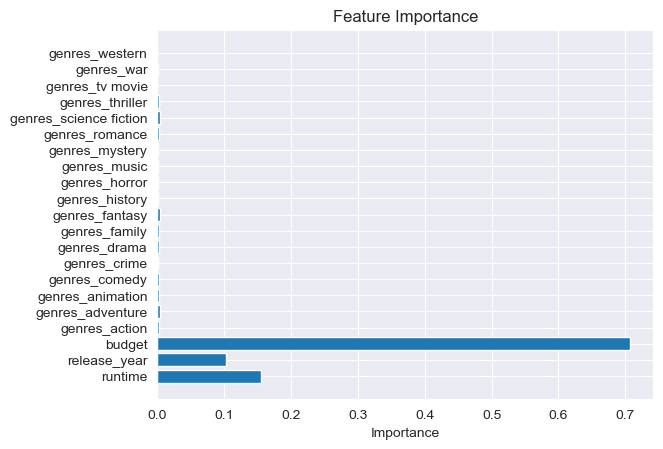

In [214]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Feature importance
importances = model.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


# production countries 

In [219]:
movies_exp2 = movies_exploded.copy().explode('production_countries')

In [283]:
country_counts = movies_exp2.groupby(['release_year', 'production_countries']).size().reset_index(name='count')
total_counts = movies_exp2.groupby(['release_year']).size().reset_index(name='total')
country_prop = country_counts.merge(total_counts, on='release_year')
country_prop['prop'] = country_prop['count'] / country_prop['total']

In [285]:
total_movies_per_country = movies_exp2.groupby('production_countries').size().reset_index(name='count')
filtered_countries = total_movies_per_country.sort_values(by='count', ascending=False)['production_countries'].head(15).tolist()
    #total_movies_per_country[total_movies_per_country['count'] > quart1]['production_countries'].tolist())
country_prop = country_prop[country_prop.production_countries.isin(filtered_countries)]

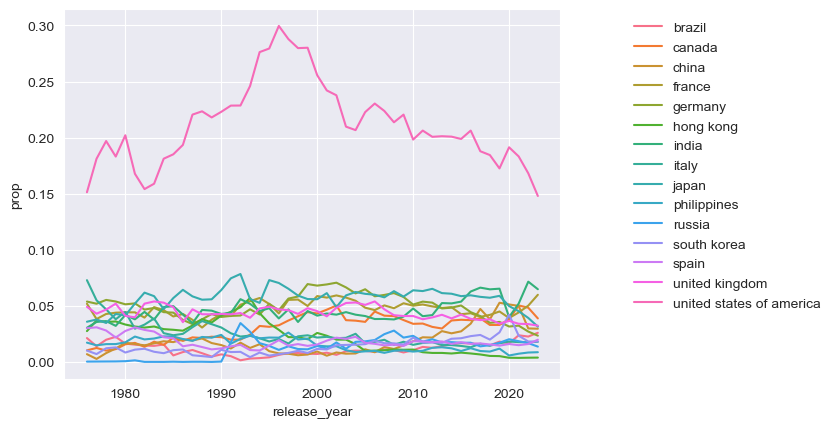

In [293]:
sns.lineplot(data=country_prop, x='release_year', y='prop', hue='production_countries')
plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1), frameon=False)

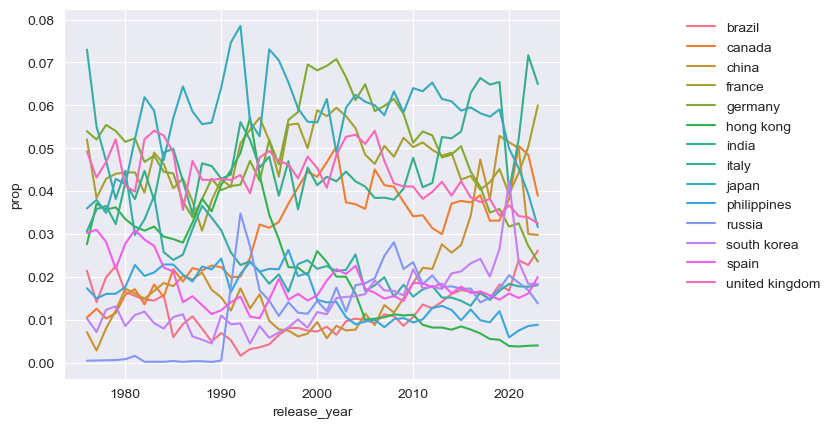

In [300]:
sns.lineplot(data=country_prop[country_prop.production_countries != 'united states of america'], x='release_year', y='prop', hue='production_countries')
plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1), frameon=False)

In [ ]:


# Count occurrences of each genre within production types and DVD eras
genre_counts = (
    movies_exploded.groupby(['success_type', 'dvd_era', 'genres'])
    .size()
    .reset_index(name='count')
)

# Total count of genres per production type and DVD era
total_counts = (
    movies_exploded.groupby(['success_type', 'dvd_era'])
    .size()
    .reset_index(name='total')
)

# Merge to compute proportions
genre_proportions = genre_counts.merge(
    total_counts,
    on=['success_type', 'dvd_era']
)
genre_proportions['proportion'] = (
    genre_proportions['count'] / genre_proportions['total']
)

mindex = pd.MultiIndex.from_arrays([['Low','Low', 'Low', 'Mid','Mid','Mid', 'Big','Big','Big', 'Super', 'Super', 'Super'], ['pre', 'during', 'post']*4], names=('success_type', 'dvd_era'))

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot data for easier plotting
pivot_data = genre_proportions.pivot_table(
    index=['success_type', 'dvd_era'],
    columns='genres',
    values='proportion',
    fill_value=0
).reindex(mindex)

# Plot
pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    colormap='tab20'
)
plt.title('Genre Proportions by Success Type and DVD Era')
plt.xlabel('Success Type, DVD Era')
plt.ylabel('Proportion')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [302]:
print(movies_exp2.production_countries.unique())

['united kingdom' 'united states of america' 'canada' 'new zealand'
 'australia' 'south africa' 'france' 'germany' 'hong kong' 'taiwan'
 'india' 'south korea' 'netherlands' 'japan' 'china' 'malta' 'bulgaria'
 'hungary' 'mexico' 'spain' 'italy' 'brazil' 'czech republic'
 'united arab emirates' 'switzerland' 'belgium' 'ireland' 'poland'
 'denmark' 'russia' 'norway' 'sweden' 'slovenia' 'romania' 'greece' nan
 'colombia' 'iceland' 'turkey' 'philippines' 'luxembourg' 'austria'
 'morocco' 'finland' 'israel' 'portugal' 'indonesia' 'thailand'
 'argentina' 'chile' 'serbia' 'solomon islands' 'dominican republic'
 'guadaloupe' 'peru' 'soviet union' 'slovakia' 'puerto rico' 'uruguay'
 'paraguay' 'ghana' 'iran' 'cyprus' 'lebanon' 'qatar' 'malawi' 'singapore'
 'malaysia' 'botswana' 'venezuela' 'iraq' 'macao' 'yugoslavia' 'lithuania'
 'cambodia' 'jordan' 'vietnam' 'kazakhstan' 'ukraine' 'ecuador' 'kenya'
 'estonia' 'georgia' 'saudi arabia' 'croatia' 'bosnia and herzegovina'
 'montenegro' 'liechtenste

In [303]:
countries_regions = {
    "united kingdom": "UK",
    "united states of america": "North America",
    "canada": "North America",
    "new zealand": "Oceania",
    "australia": "Oceania",
    "south africa": "Africa",
    "france": "Western Europe",
    "germany": "Western Europe",
    "hong kong": "Eastern Asia",
    "taiwan": "Eastern Asia",
    "india": "Southern Asia",
    "south korea": "Eastern Asia",
    "netherlands": "Western Europe",
    "japan": "Eastern Asia",
    "china": "Eastern Asia",
    "malta": "Western Europe",
    "bulgaria": "Eastern Europe",
    "hungary": "Eastern Europe",
    "mexico": "North America",
    "spain": "Western Europe",
    "italy": "Western Europe",
    "brazil": "South America",
    "czech republic": "Eastern Europe",
    "united arab emirates": "Middle East",
    "switzerland": "Western Europe",
    "belgium": "Western Europe",
    "ireland": "UK",
    "poland": "Eastern Europe",
    "denmark": "Western Europe",
    "russia": "Russia",
    "norway": "Western Europe",
    "sweden": "Western Europe",
    "slovenia": "Eastern Europe",
    "romania": "Eastern Europe",
    "greece": "Eastern Europe",
    "colombia": "South America",
    "iceland": "Western Europe",
    "turkey": "Western Asia",
    "philippines": "Eastern Asia",
    "luxembourg": "Western Europe",
    "austria": "Western Europe",
    "morocco": "Africa",
    "finland": "Western Europe",
    "israel": "Western Asia",
    "portugal": "Western Europe",
    "indonesia": "Southeast Asia",
    "thailand": "Southeast Asia",
    "argentina": "South America",
    "chile": "South America",
    "serbia": "Eastern Europe",
    "solomon islands": "Oceania",
    "dominican republic": "Caribbean",
    "guadaloupe": "Caribbean",
    "peru": "South America",
    "soviet union": "Russia",
    "slovakia": "Eastern Europe",
    "puerto rico": "Caribbean",
    "uruguay": "South America",
    "paraguay": "South America",
    "ghana": "Africa",
    "iran": "Western Asia",
    "cyprus": "Eastern Europe",
    "lebanon": "Western Asia",
    "qatar": "Middle East",
    "malawi": "Africa",
    "singapore": "Southeast Asia",
    "malaysia": "Southeast Asia",
    "botswana": "Africa",
    "venezuela": "South America",
    "iraq": "Middle East",
    "macao": "Eastern Asia",
    "yugoslavia": "Eastern Europe",
    "lithuania": "Eastern Europe",
    "cambodia": "Southeast Asia",
    "jordan": "Middle East",
    "vietnam": "Southeast Asia",
    "kazakhstan": "Central Asia",
    "ukraine": "Eastern Europe",
    "ecuador": "South America",
    "kenya": "Africa",
    "estonia": "Eastern Europe",
    "georgia": "Eastern Europe",
    "saudi arabia": "Middle East",
    "croatia": "Eastern Europe",
    "bosnia and herzegovina": "Eastern Europe",
    "montenegro": "Eastern Europe",
    "liechtenstein": "Western Europe",
    "panama": "Central America",
    "algeria": "Africa",
    "belarus": "Eastern Europe",
    "myanmar": "Southeast Asia",
    "bahamas": "Caribbean",
    "kuwait": "Middle East",
    "libyan arab jamahiriya": "Africa",
    "bolivia": "South America",
    "aruba": "Caribbean",
    "guatemala": "Central America",
    "cuba": "Caribbean",
    "albania": "Eastern Europe",
    "tunisia": "Africa",
    "czechoslovakia": "Eastern Europe",
    "jamaica": "Caribbean",
    "nigeria": "Africa",
    "namibia": "Africa",
    "palestinian territory": "Middle East",
    "senegal": "Africa",
    "macedonia": "Eastern Europe",
    "angola": "Africa",
    "netherlands antilles": "Caribbean",
    "zimbabwe": "Africa",
    "egypt": "Africa",
    "serbia and montenegro": "Eastern Europe",
    "rwanda": "Africa",
    "bhutan": "Southern Asia",
    "cameroon": "Africa",
    "latvia": "Eastern Europe",
    "uganda": "Africa",
    "mauritius": "Africa",
    "burkina faso": "Africa",
    "zambia": "Africa",
    "afghanistan": "Southern Asia",
    "french polynesia": "Oceania",
    "congo": "Africa",
    "vanuatu": "Oceania",
    "cayman islands": "Caribbean",
    "new caledonia": "Oceania",
    "tanzania": "Africa",
    "pakistan": "Southern Asia",
    "nepal": "Southern Asia",
    "sri lanka": "Southern Asia",
    "azerbaijan": "Western Asia",
    "mongolia": "Eastern Asia",
    "nicaragua": "Central America",
    "cote d'ivoire": "Africa",
    "honduras": "Central America",
    "costa rica": "Central America",
    "mali": "Africa",
    "liberia": "Africa",
    "armenia": "Western Asia",
    "lao people's democratic republic": "Southeast Asia",
    "ethiopia": "Africa",
    "st. pierre and miquelon": "North America",
    "mozambique": "Africa",
    "uzbekistan": "Central Asia",
    "north korea": "Eastern Asia",
    "bangladesh": "Southern Asia",
    "northern ireland": "UK",
    "east germany": "Western Europe",
    "kosovo": "Eastern Europe",
    "guinea": "Africa",
    "timor-leste": "Southeast Asia",
    "barbados": "Caribbean",
    "sudan": "Africa",
    "tajikistan": "Central Asia",
    "greenland": "North America",
    "swaziland": "Africa",
    "turks and caicos islands": "Caribbean",
    "chad": "Africa",
    "haiti": "Caribbean",
    "martinique": "Caribbean",
    "yemen": "Middle East",
    "lesotho": "Africa",
    "andorra": "Western Europe",
    "monaco": "Western Europe",
    "mauritania": "Africa",
    "st. kitts and nevis": "Caribbean",
    "moldova": "Eastern Europe",
    "madagascar": "Africa",
    "el salvador": "Central America",
    "djibouti": "Africa",
    "somalia": "Africa",
    "trinidad and tobago": "Caribbean",
    "kyrgyz republic": "Central Asia",
    "samoa": "Oceania",
    "faeroe islands": "Oceania",
    "benin": "Africa",
    "zaire": "Africa",
    "fiji": "Oceania",
    "anguilla": "Caribbean",
    "gibraltar": "Europe",
    "central african republic": "Africa",
    "syrian arab republic": "Western Asia",
    "equatorial guinea": "Africa",
    "cape verde": "Africa",
    "suriname": "South America",
    "bermuda": "North America",
    "guinea-bissau": "Africa",
    "turkmenistan": "Central Asia",
    "gabon": "Africa",
    "svalbard & jan mayen islands": "Europe",
    "guyana": "South America",
    "united states minor outlying islands": "North America",
    "niger": "Africa",
    "gambia": "Africa",
    "falkland islands": "South America",
    "brunei darussalam": "Southeast Asia",
    "cook islands": "Oceania",
    "st. lucia": "Caribbean",
    "belize": "Central America",
    "antigua and barbuda": "Caribbean",
    "burundi": "Africa",
    "togo": "Africa",
    "papua new guinea": "Oceania",
    "marshall islands": "Oceania",
    "grenada": "Caribbean",
    "oman": "Middle East",
    "bahrain": "Middle East",
    "comoros": "Africa",
    "antarctica": "Antarctica",
    "sierra leone": "Africa",
    "tonga": "Oceania",
    "san marino": "Western Europe",
    "maldives": "Southern Asia",
    "seychelles": "Africa",
    "norfolk island": "Oceania",
    "american samoa": "Oceania",
    "reunion": "Africa",
    "sao tome and principe": "Africa",
    "french guiana": "South America",
    "eritrea": "Africa",
    "guam": "Oceania",
    "us virgin islands": "North America",
    "mayotte": "Africa",
    "st. vincent and the grenadines": "Caribbean",
    "south sudan": "Africa",
    "northern mariana islands": "Oceania"
}


In [325]:
movies_exp2['region'] = movies_exp2.production_countries.apply(lambda x: countries_regions[x] if pd.notna(x) else None )
movies_wregions = movies_exp2.dropna(subset=['region'])

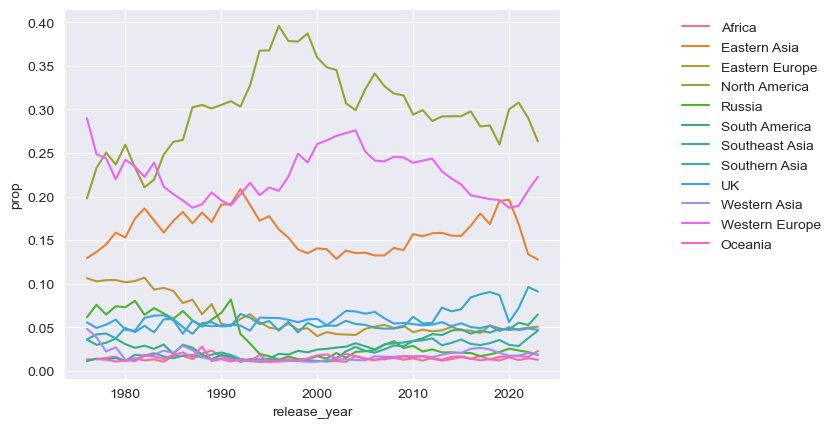

In [328]:

region_counts = movies_wregions.groupby(['release_year', 'region']).size().reset_index(name='count')
filtered_regions = region_counts.groupby('region').sum('count').sort_values(by='count', ascending=False).reset_index().head(16).region.to_list()
total_counts = movies_wregions.groupby(['release_year']).size().reset_index(name='total')
region_prop = region_counts.merge(total_counts, on='release_year')
region_prop['prop'] = region_prop['count'] / region_prop['total']
total_movies_per_region = movies_wregions.groupby('region').size().reset_index(name='count')
#filtered_countries = total_movies_per_country.sort_values(by='count', ascending=False)['production_countries'].head(
#    15).tolist()
#total_movies_per_country[total_movies_per_country['count'] > quart1]['production_countries'].tolist())
#country_prop = country_prop[country_prop.production_countries.isin(filtered_countries)]
sns.lineplot(data=region_prop[region_prop.prop > 0.01], x='release_year', y='prop', hue='region')
plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1), frameon=False)